# POPTICS
step1.CLEAN THE RAW DATA TO THE CORRECT INPUT FORMAT OF POPTICS
step2.USE POPTICS TO EACH USER AND GET THE CLUSTERS OF EACH USER

In [5]:
l = []
w = []
class A:
    def __init__(self,a,b):
        self.a = a;
        self.b = b
# aa = A(-73.989450756723, 40.74481949770078)
# for i in range(100000):
#     l.append(aa)
bb = A(-73.989450756723, 40.74481949770079)
i = 3
while i > 0:
    if bb not in l:
        print("false")
        print(bb.a, bb.b)
        l.append(bb)
        w.append(1)
        print(l.index(bb))
    else:
        w[l.index(bb)] += 1
    print(w)
    i -= 1
print(l[0].a,l[0].b)

false
-73.989450756723 40.74481949770079
0
[1]
[2]
[3]
-73.989450756723 40.74481949770079


In [6]:
# Copyright (c) 2012, Ryan Gomba
# All rights reserved.
# 
# Redistribution and use in source and binary forms, with or without
# modification, are permitted provided that the following conditions are met:
# 
# 1. Redistributions of source code must retain the above copyright notice, this
#    list of conditions and the following disclaimer. 
# 2. Redistributions in binary form must reproduce the above copyright notice,
#    this list of conditions and the following disclaimer in the documentation
#    and/or other materials provided with the distribution.
# 
# THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS" AND
# ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED
# WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE
# DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT OWNER OR CONTRIBUTORS BE LIABLE FOR
# ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES
# (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES;
# LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND
# ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT
# (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE OF THIS
# SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.
# 
# The views and conclusions contained in the software and documentation are those
# of the authors and should not be interpreted as representing official policies, 
# either expressed or implied, of the FreeBSD Project.

import math
import json
import numpy as np

################################################################################
# POINT
################################################################################

class Point:
    
    def __init__(self, latitude, longitude):
        
        self.latitude = latitude
        self.longitude = longitude
        self.cd = None              # core distance
        self.rd = None              # reachability distance
        self.processed = False      # has this point been processed?
        
    def __eq__(self, other):
             if self.latitude == other.latitude and self.longitude==other.longitude:
                  return True
             else:
                  return False
        
    # --------------------------------------------------------------------------
    # calculate the distance between any two points on earth
    # --------------------------------------------------------------------------
    
    def distance(self, point):
        
        # convert coordinates to radians
        
        p1_lat, p1_lon, p2_lat, p2_lon = [math.radians(c) for c in
            [self.latitude, self.longitude, point.latitude, point.longitude]]
        
        numerator = math.sqrt(
            math.pow(math.cos(p2_lat) * math.sin(p2_lon - p1_lon), 2) +
            math.pow(
                math.cos(p1_lat) * math.sin(p2_lat) -
                math.sin(p1_lat) * math.cos(p2_lat) *
                math.cos(p2_lon - p1_lon), 2))

        denominator = (
            math.sin(p1_lat) * math.sin(p2_lat) +
            math.cos(p1_lat) * math.cos(p2_lat) *
            math.cos(p2_lon - p1_lon))
        
        # convert distance from radians to meters
        # note: earth's radius ~ 6372800 meters
        
        return math.atan2(numerator, denominator) * 6372800
        
    # --------------------------------------------------------------------------
    # point as GeoJSON
    # --------------------------------------------------------------------------
        
    def to_geo_json_dict(self, properties=None):
        
        return {
            'type': 'Feature',
            'geometry': {
                'type': 'Point',
                'coordinates': [
                    self.longitude,
                    self.latitude,
                ]
            },
            'properties': properties,
        }
 
    def __repr__(self):
        return '(%f, %f)' % (self.latitude, self.longitude)

################################################################################
# CLUSTER
################################################################################

class Cluster:
    
    def __init__(self, points):
        
        self.points = points
        
    # --------------------------------------------------------------------------
    # calculate the centroid for the cluster
    # --------------------------------------------------------------------------

    def centroid(self):
        
        return Point(sum([p.latitude for p in self.points])/len(self.points),
            sum([p.longitude for p in self.points])/len(self.points))
            
    # --------------------------------------------------------------------------
    # calculate the region (centroid, bounding radius) for the cluster
    # --------------------------------------------------------------------------
    
    def region(self):
        
        centroid = self.centroid()
        radius = reduce(lambda r, p: max(r, p.distance(centroid)), self.points)
        return centroid, radius
        
    # --------------------------------------------------------------------------
    # cluster as GeoJSON
    # --------------------------------------------------------------------------
        
    def to_geo_json_dict(self, user_properties=None):
        
        center, radius = self.region()
        properties = { 'radius': radius }
        if user_properties: properties.update(user_properties)
        
        return {
            'type': 'Feature',
            'geometry': {
                'type': 'Point',
                'coordinates': [
                    center.longitude,
                    center.latitude,
                ]
            },
            'properties': properties,
        }

################################################################################
# OPTICS
################################################################################

class Optics:
    
    def __init__(self, points, max_radius, min_cluster_size):
        
        self.points = points
        self.max_radius = max_radius                # maximum radius to consider
        self.min_cluster_size = min_cluster_size    # minimum points in cluster
        self.rd = []
    # --------------------------------------------------------------------------
    # get ready for a clustering run
    # --------------------------------------------------------------------------
    
    def _setup(self):
        
        for p in self.points:
            p.rd = None
            p.processed = False
        self.unprocessed = [p for p in self.points]
        self.ordered = []

    # --------------------------------------------------------------------------
    # distance from a point to its nth neighbor (n = min_cluser_size)
    # --------------------------------------------------------------------------
    
    def _core_distance(self, point, neighbors):
        if point.cd is not None: return point.cd
        if len(neighbors) >= self.min_cluster_size - 1:
            sorted_neighbors = sorted([n.distance(point) for n in neighbors])
            point.cd = sorted_neighbors[self.min_cluster_size - 2] # index(0 start and itself is in cluster)
            return point.cd
        
    # --------------------------------------------------------------------------
    # neighbors for a point within max_radius
    # --------------------------------------------------------------------------
    
    def _neighbors(self, point):
        
        return [p for p in self.points if p is not point and  #p is not itself
            p.distance(point) <= self.max_radius]
            
    # --------------------------------------------------------------------------
    # mark a point as processed
    # --------------------------------------------------------------------------
        
    def _processed(self, point):
    
        point.processed = True
        self.unprocessed.remove(point)
        self.ordered.append(point)
    
    # --------------------------------------------------------------------------
    # update seeds if a smaller reachability distance is found
    # --------------------------------------------------------------------------

    def _update(self, neighbors, point, seeds):
        
        # for each of point's unprocessed neighbors n...

        for n in [n for n in neighbors if not n.processed]:
            
            # find new reachability distance new_rd
            # if rd is null, keep new_rd and add n to the seed list
            # otherwise if new_rd < old rd, update rd
            
            new_rd = max(point.cd, point.distance(n))
            if n.rd is None:
                n.rd = new_rd
                seeds.append(n)
            elif new_rd < n.rd:
                n.rd = new_rd
    
    # --------------------------------------------------------------------------
    # run the OPTICS algorithm
    # --------------------------------------------------------------------------

    def run(self):
        
        self._setup()
        
        # for each unprocessed point (p)...
        
        while self.unprocessed:
            point = self.unprocessed[0]
            #point.rd = 0
            # mark p as processed
            # find p's neighbors
            
            self._processed(point)
            point_neighbors = self._neighbors(point)

            # if p has a core_distance, i.e has min_cluster_size - 1 neighbors

            if self._core_distance(point, point_neighbors) is not None:
                
                # update reachability_distance for each unprocessed neighbor
                
                seeds = []
                self._update(point_neighbors, point, seeds)
                
                # as long as we have unprocessed neighbors...
                
                while(seeds):
                    
                    # find the neighbor n with smallest reachability distance
                    
                    seeds.sort(key=lambda n: n.rd)
                    n = seeds.pop(0)
                    
                    # mark n as processed
                    # find n's neighbors
                    
                    self._processed(n)
                    n_neighbors = self._neighbors(n)
                    
                    # if p has a core_distance...
                    
                    if self._core_distance(n, n_neighbors) is not None:
                        
                        # update reachability_distance for each of n's neighbors
                        
                        self._update(n_neighbors, n, seeds)
        
        self.reset_rd();
        # when all points have been processed
        # return the ordered list

        return self.ordered
    
    def reset_rd(self):
        for point in self.ordered:
            point.rd = point.rd if point.rd else self.max_radius+100
            self.rd.append(point.rd) 
    # --------------------------------------------------------------------------
    # add score to decide the cluster_threshold
    def _score(self):
        N = len(self.rd)
        rd = [rd for rd in self.rd]
        #print(rd)
        #rd = [point.rd for point in self.ordered if point.rd is not None]
        rd.sort()
        #print(rd)
        rdth = 0
        min_score = np.inf
        #print(self.ordered)
        for i in range(len(self.rd)):
            if i >= self.min_cluster_size - 1:
                #print(np.std(rd[0:i]),N,i)
                score = np.std(rd[0:i])*(N/i);
                if score < min_score:
                    min_score = score
                    rdth = rd[i]
        #print(rdth)
        return rdth
        
    def cluster(self):
        
#         cd = []
#         for point in self.ordered:
#             if point.cd is not None:
#                 cd.append(point.cd)
#         #print(cd)
#         cd.sort()
        #print("2*cd_min: ", 2*cd[0])
        #print(self._score())
        #cluster_threshold = 2*cd[0]
        #cluster_threshold = 3000
        cluster_threshold = self._score()
        
        
        clusters = []
        separators = []
        
        for i in range(len(self.ordered)):
            this_i = i
            next_i = i + 1
            this_p = self.ordered[i]
            this_rd = this_p.rd if this_p.rd else float('infinity')
            # use an upper limit to separate the clusters
            
            if this_rd > cluster_threshold:
                separators.append(this_i)

        separators.append(len(self.ordered))
        #print(separators)

        for i in range(len(separators) - 1):
            start = separators[i]
            end = separators[i + 1]
            #print(end - start)
            if end - start >= self.min_cluster_size:
                clusters.append(Cluster(self.ordered[start:end]))

        return clusters
    
    def bar(self):
        plt.bar(range(len(self.rd)),self.rd, width=1.0)
        plt.show()
#         for re in self.rd:
#             if re == 0:
#                 print("whatever")
#                 print(self.rd.index(re))
                
#     def hist(self):
#         plt.hist(range(len(self.rd)),self.rd, bins = len(self.rd))
#         plt.show()
    
    def getRD(self):
        return self.rd

# LOAD SOME POINTS

# points = [
#     Point(37.769006, -122.429299), # cluster #1
#     Point(37.769044, -122.429130), # cluster #1
#     Point(37.768775, -122.429092), # cluster #1
#     Point(37.776299, -122.424249), # cluster #2
#     Point(37.776265, -122.424657)] # cluster #2


# optics = Optics(points, 1000, 2) # 100m radius for neighbor consideration, cluster size >= 2 points
# optics.run()                    # run the algorithm
# clusters = optics.cluster()   # 50m threshold for clustering

# for cluster in clusters:
#     print(cluster.points)

    

In [7]:
p1 = Point(1.0, 2.0)
p2 = Point(1.0, 2.0)
print(p1 == p2)
print(p1.latitude == p2.latitude)
print(p1.longitude == p2.longitude)
print(p1.cd == p2.cd)
print(p1.rd == p2.rd)
print(p1.processed == p2.processed)

True
True
True
True
True
True


# step1.CLEAN THE RAW DATA TO THE CORRECT INPUT FORMAT OF POPTICS

In [8]:
print("Run our poptics")
#import numpy as np
from collections import defaultdict
#import source.optics as OP

# ------------------------open file--------------------------------#
nyc = open("./nyc.txt", encoding='ISO-8859-1')
#------------------------------------------------------------------#

'''
the dictonary 'user_checkin_history' (defined below) contains inputs to POPTICS
Data format:
{
    user_1 : [(venue_category_1, lantitude_1, longtitude_1), (venue_category_2, lantitude_2, longtitude_2) ...],
    user_2 : [(venue_category_i, lantitude_i, longtitude_i), (venue_category_i+1, lantutide_i+1, longtitude_i+1) ...],
    user_3 : [...],
    ...    :  ... ,
    user_n : [...]
}
'''
#user_checkin_history = dict.fromkeys(range(4), []) #d
#user_checkin_w = dict.fromkeys(range(4), []) #defaultdict([])
user_checkin_history =  defaultdict(list)
user_checkin_w = defaultdict(list)

#---------------------extract data from file-----------------------------#
for line in nyc:
    # index 3 : venue category, 4 : Latitude, 5 : Longitude
    lst = line.split('\t')
    
    # lantitude and longtitude
    lantitude = float(lst[4])
    longtitude = float(lst[5])
    
    # venue category, combine categories into a single category
    category = lst[3]
    if 'Restaurant' in category:
        venue_category = 'Restaurant'
    elif 'Joint' in category:
        venue_category = 'Food Joint'
    elif 'Museum' in category:
        venue_category = 'Museum'
    else:
        venue_category = category
    
    # construct the checkin
    single_checkin = (venue_category, lantitude, longtitude)
    
    # add this checking location, lst[0] is the user's id
    user_checkin_history[lst[0]].append(single_checkin)
#----------------------------------------------------------------------#



#-------------------remove insignificant venues categories and users-----------#
# format : {venue_category_1 : count 1, venue_category_2 : count 2, ...}
venue_count = defaultdict(lambda : 0)
for user, checkins in user_checkin_history.items():
    for checkin in checkins:
        venue_count[checkin[0]] += 1

# delete all checkins whose venue categories have not been visited over 1200 times
for user, checkins in user_checkin_history.items():
    new_checkins = []
    for checkin in checkins:
        if venue_count[checkin[0]] >= 1200:
            p = Point(checkin[1],checkin[2])
            new_checkins.append(p)             
    user_checkin_history[user] = new_checkins

# remove users who visited less than 100 places
remove = []
for user, checkins in user_checkin_history.items():
    if len(checkins) < 100:
        remove.append(user)
for r in remove:
    del user_checkin_history[r]
#----------------------------------------------------------------------------------#


#---------------------------Remaining users---------------------------#
users = []
for user in user_checkin_history.keys():
    users.append(user)
    print(user,":", len(user_checkin_history[user]))
#---------------------------------------------------------------------#
user =  "453"
print(len(user_checkin_history[user]))
for checkin in user_checkin_history[user]:
    print((checkin.latitude, checkin.longitude))

# for userid in user_checkin_history.keys():
#      print(userid)
#print(user_checkin_history['80'])


Run our poptics
470 : 125
69 : 367
87 : 117
484 : 687
642 : 275
428 : 129
877 : 150
691 : 186
116 : 102
445 : 752
895 : 224
704 : 124
891 : 297
901 : 397
699 : 283
100 : 151
443 : 663
689 : 731
390 : 345
32 : 103
230 : 147
834 : 352
962 : 180
1032 : 100
525 : 149
318 : 100
1047 : 375
738 : 113
364 : 174
398 : 180
839 : 137
424 : 116
751 : 156
889 : 286
612 : 185
643 : 250
718 : 214
768 : 724
15 : 159
458 : 722
280 : 449
1016 : 238
281 : 214
276 : 160
80 : 224
673 : 279
337 : 121
916 : 197
639 : 143
752 : 189
713 : 135
1012 : 236
438 : 265
217 : 205
656 : 100
225 : 118
628 : 286
504 : 152
164 : 232
235 : 175
118 : 100
1054 : 389
881 : 540
706 : 659
143 : 110
1005 : 119
912 : 139
537 : 120
868 : 167
1055 : 196
907 : 108
303 : 107
793 : 141
784 : 237
734 : 342
540 : 217
816 : 368
623 : 193
294 : 108
615 : 128
173 : 118
16 : 103
7 : 212
592 : 112
636 : 104
865 : 172
621 : 408
272 : 115
591 : 174
976 : 537
562 : 124
783 : 145
319 : 415
468 : 167
874 : 102
107 : 114
667 : 173
557 : 183
725 :

# step2.USE POPTICS TO EACH USER AND GET THE CLUSTERS OF EACH USER
#number of user : 782
#FOR EACH USER RUN POPTICS:
#input : locations of one user, yita
#output : clusters of user locations

In [9]:
import matplotlib.pyplot as plt
import matplotlib
print(matplotlib.__version__)


2.2.2


In [10]:
class POPTICS:
    def __init__(self, points, yita):
        self.points = points
        self.poptics = Optics(points, 10000, yita)
    
    def run(self):
        self.poptics.run()
        clusters = self.poptics.cluster()  
#         n = 0
#         for cluster in clusters:
#             points = cluster.points
#             n + len(points)
        return clusters
    
    def show(self):
        self.poptics.bar()
        #self.poptics.hist()
        rd = self.poptics.getRD()
        print(rd)
        
# run POPTICS on every user(note that the user id '10' is a string):
# GL = defaultdict(list)
# for user in users:
#     GL[user].append(POPTICS(user_checkin_history[user], len(user_checkin_history[user])//20))
    


# The poptics result of user 185

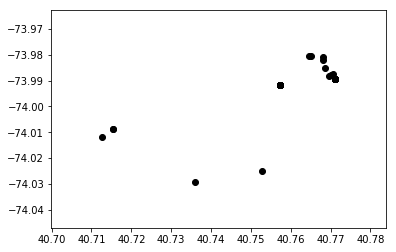

In [11]:
user = "453"
x = []
y = []
for point in user_checkin_history[user]:
    x.append(point.latitude)
    y.append(point.longitude)
plt.scatter(x, y, color='black')
plt.show()

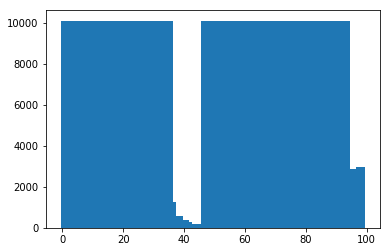

[10100, 10100, 10100, 10100, 10100, 10100, 10100, 10100, 10100, 10100, 10100, 10100, 10100, 10100, 10100, 10100, 10100, 10100, 10100, 10100, 10100, 10100, 10100, 10100, 10100, 10100, 10100, 10100, 10100, 10100, 10100, 10100, 10100, 10100, 10100, 10100, 10100, 1249.1117435589806, 599.4004297593366, 565.2404218238596, 392.5975277215252, 386.19466884893006, 293.92596603962363, 176.16652153294223, 176.16652153294223, 175.64125338185653, 10100, 10100, 10100, 10100, 10100, 10100, 10100, 10100, 10100, 10100, 10100, 10100, 10100, 10100, 10100, 10100, 10100, 10100, 10100, 10100, 10100, 10100, 10100, 10100, 10100, 10100, 10100, 10100, 10100, 10100, 10100, 10100, 10100, 10100, 10100, 10100, 10100, 10100, 10100, 10100, 10100, 10100, 10100, 10100, 10100, 10100, 10100, 10100, 10100, 2858.5448957323797, 2858.5448957323797, 2989.1207703016476, 2989.1207703016476, 2989.1207703019813]


In [12]:
POP = POPTICS(user_checkin_history[user], len(user_checkin_history[user])//20)
GL = POP.run()
#GL = POPTICS(user_checkin_history[user], 50 )
# for cluster in GL:
#     print(cluster.points)
POP.show()

0


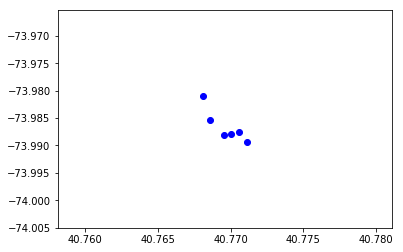

100
6
94


In [13]:
account = 0
color = ["blue", "yellow", "green", "red", "gray"]
for i,cluster in enumerate(GL):
    x = []
    y = []
    account += len(cluster.points)
    for point in cluster.points:
        x.append(point.latitude)
        y.append(point.longitude)
    print(i)
    plt.scatter(x, y, color = color[i])
    #plt.axis([40.9649, 40.9665, -74.062, -74.064])
    plt.show()
print(len(user_checkin_history[user]))
print(account)
print(len(user_checkin_history[user])- account)

In [14]:
user_clusters = defaultdict(list)
for user in users:
    #print(user)
    POP = POPTICS(user_checkin_history[user], len(user_checkin_history[user])//20)
    user_clusters[user] = POP.run()
print("finish")

finish


In [ ]:
# import numpy as np
#from scipy.spatial.distance import pdist, squarefrom
# def gaussian(x, mu, sig):
#     return 1/(np.sqrt(2*np.pi*np.power(sig,2)))*np.exp(-np.power((x-mu)/sig, 2)/2)
def gaussian_2d(x, y, mu_x, mu_y, sig):
    exp_value = -(np.power(x-mu_x, 2)+np.power(y-mu_y, 2))/(2*np.power(sig, 2))
    return 1/(np.sqrt(2*np.pi*np.power(sig,2)))*np.exp(exp_value)

venueID = []

user_clusterID = defaultdict(list)
for user in user_checkin_history:
    for p in user:
        for i,cluster in enumerate(user_clusters):
            if p is in cluster:
                user_clusterID[user].append(i)
                break

#demand level
venues = [] #[(user1, user2 ...), (user1, user2, ...)]
venue_user = [] #[venue1(user1, user2 ...), venue2(user1, user2 ...) ...]
venue_pattern = [] #[pattern1(venue1, venue2, ...)]

for venue in venue_user:
    for user in venue:
        this_center = user_clusters[user][].center
        this_radius = user_cluster.radius
        d = gaussian_2d(venue.x, venue.y, this_center.x, this_center.y, this_radius)
    demand[venue] += d

#total demand
for pattern in patterns:
    for venue in pattern_list(pattern):
        dt = demand[venue]
        totaldemand[pattern] += dt
    
#supply level
#standard deviation for supply

def distance_venue(venue, user_list):
    for user in user_list:
        dist = np.sqrt(np.power(user.x-venue.x, 2)+np.power(user.y-venue.y, 2))
        total_dist += dist
    average_dist(venue) = total_dist / numberofuser
    return average_dist

for venue in venues:
    for user in veune_user(venue):
        s = gaussian_2d(user.x, user.y, venue.x, venue.y, average_dist(venue))
    supply[venue] += s

#total supply
for pattern in patterns:
    for venue in pattern_list(pattern):
        st = supply[venue]
        totalsupply[pattern] += st
